# Stacked LSTM - Time Serise Dataset

* 서울시 기후 데이터 : 2011년 01월 01일 ~ 2019년 12월 31일
* https://data.kma.go.kr/cmmn/main.do
* 기후통계분석 -> 기온분석 -> 기간(20110101~20191231) -> 검색 -> CSV 다운로드
* Seoul_Temp.csv

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import Packages

* Packages

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [3]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)

temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


# II. Data Preprocessing

> ## 1) 일일 평균온도('avg') 변화 시각화

* 일일 평균온도 변화에 일정한 패턴 확인

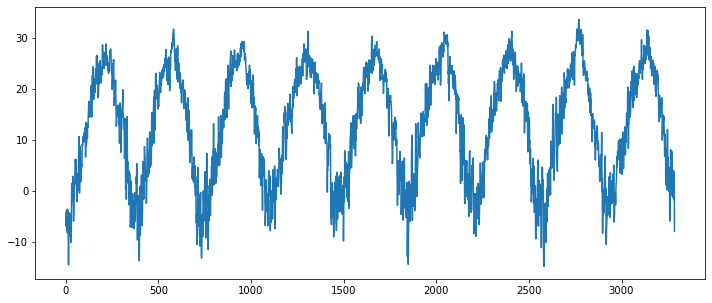

In [4]:
temp_data = temp[['avg']]

plt.figure(figsize = (12, 5))
plt.plot(temp_data)
plt.show()

> ## 2) Normalization

* tanh Activation 적용을 위해 -1 ~ 1 범위로 정규화

In [5]:
scaler = MinMaxScaler(feature_range = (-1, 1))

temp_data = scaler.fit_transform(temp_data)

> ## 3) Train vs. Test Split

* Train_Dataset : 2011년 01월 01일 ~ 2017년 12월 31일
* Test_Dataset : 2018년 01월 01일 ~ 2019년 12월 31일

In [6]:
train = temp_data[0:2557]
test  = temp_data[2557:]

# III. 시계열 데이터 처리 함수

> ## 1) 시계열 학습용 데이터 생성 함수 정의

* X : 학습 평균온도 데이터
* y : 정답 평균온도 데이터
* 일정 기간의 X로 y를 예측하도록 학습

In [7]:
def create_dataset(time_data, look_back = 1):
    data_X, data_y = [], []

    for i in range(len(time_data) - look_back):
        data_X.append(time_data[i:(i + look_back), 0])
        data_y.append(time_data[i + look_back, 0])

    return np.array(data_X), np.array(data_y)

> ## 2) loop_back 기간 설정 후 학습데이터 생성

* 180일 기간 평균온도로 다음날 평균온도 예측 데이터 생성

In [8]:
look_back = 180

train_X, train_y = create_dataset(train, look_back)
test_X,  test_y  = create_dataset(test, look_back)

> ## 3) Tensor Reshape

In [9]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180, 1), (2377,), (550, 180, 1), (550,))

# IV. Stacked LSTM Modeling

> ## 1) Model Define

In [10]:
model = Sequential(name = 'Stackd_LSTM')
model.add(LSTM(64, 
               input_shape = (None, 1), 
               return_sequences = True))
model.add(LSTM(64,
               input_shape = (None, 1),
               return_sequences = False))
model.add(Dense(1, activation = 'tanh'))

* Model Summary

In [11]:
model.summary()

Model: "Stackd_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


> ## 2) Model Compile

In [12]:
model.compile(loss = 'mean_squared_error', 
              optimizer = 'adam')

> ## 3) Model Fit

* 약 10분

In [13]:
%%time

hist = model.fit(train_X, train_y,
                 epochs = 200, 
                 batch_size = 16,  
                 validation_data = (test_X, test_y))

Epoch 1/200
149/149 [==============================] - 5s 15ms/step - loss: 0.0268 - val_loss: 0.0161
Epoch 2/200
149/149 [==============================] - 2s 12ms/step - loss: 0.0178 - val_loss: 0.0157
Epoch 3/200
149/149 [==============================] - 2s 12ms/step - loss: 0.0159 - val_loss: 0.0128
Epoch 4/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0145 - val_loss: 0.0120
Epoch 5/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0126 - val_loss: 0.0106
Epoch 6/200
149/149 [==============================] - 2s 12ms/step - loss: 0.0101 - val_loss: 0.0078
Epoch 7/200
149/149 [==============================] - 2s 12ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 8/200
149/149 [==============================] - 2s 12ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 9/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0085 - val_loss: 0.0077
Epoch 10/200
149/149 [==============================] - 2s 12ms/step - loss: 0.008

149/149 [==============================] - 2s 12ms/step - loss: 0.0042 - val_loss: 0.0132
Epoch 160/200
149/149 [==============================] - 2s 12ms/step - loss: 0.0043 - val_loss: 0.0138
Epoch 161/200
149/149 [==============================] - 2s 12ms/step - loss: 0.0044 - val_loss: 0.0127
Epoch 162/200
149/149 [==============================] - 2s 12ms/step - loss: 0.0042 - val_loss: 0.0144
Epoch 163/200
149/149 [==============================] - 2s 12ms/step - loss: 0.0042 - val_loss: 0.0134
Epoch 164/200
149/149 [==============================] - 2s 12ms/step - loss: 0.0040 - val_loss: 0.0123
Epoch 165/200
149/149 [==============================] - 2s 12ms/step - loss: 0.0040 - val_loss: 0.0134
Epoch 166/200
149/149 [==============================] - 2s 12ms/step - loss: 0.0041 - val_loss: 0.0131
Epoch 167/200
149/149 [==============================] - 2s 12ms/step - loss: 0.0040 - val_loss: 0.0123
Epoch 168/200
149/149 [==============================] - 2s 12ms/step - loss: 

> ## 4) 학습결과 시각화

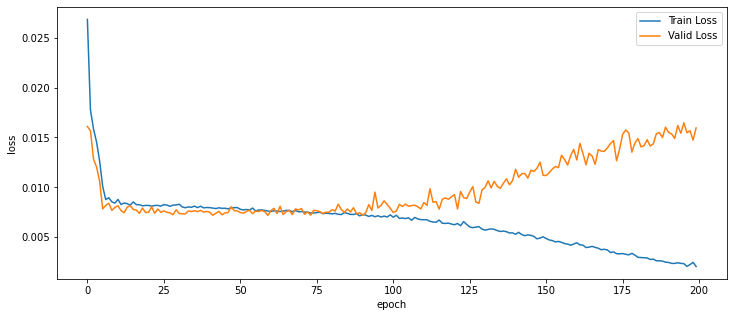

In [14]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

> ## 5) Model Evaluate

In [15]:
trainScore = model.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  0.0017419313080608845
Test Score:  0.015957944095134735


# V. Model Predict

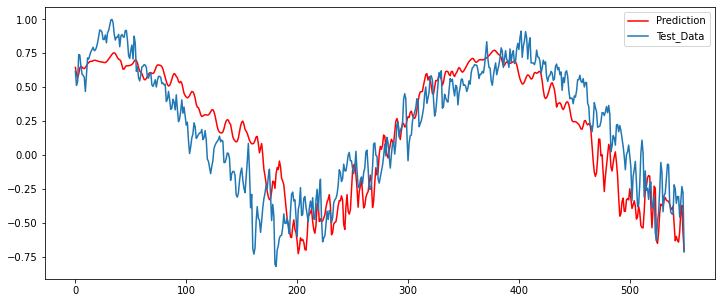

In [16]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
    
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()